In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

df = pd.read_csv("../datasets/Google.csv")
df.index = pd.DatetimeIndex(df['Date'].values)
close = df["Close"]

In [16]:
import numpy as np
import pandas as pd


def get_weights(d, size):
    w = [1.]
    for k in range(1, size):
        w_ = -w[-1] / k * (d - k + 1)
        w.append(w_)
    w = np.array(w[::-1]).reshape(-1, 1)
    return w


def plot_weights(d_range, n_plots, size):
    w = pd.DataFrame()
    for d in np.linspace(d_range[0], d_range[1], n_plots):
        w_ = get_weights(d, size)
        w_ = pd.DataFrame(w_, index=range(w_.shape[0])[::-1], columns=[d])
        w = w.join(w_, how='outer')
    ax = w.plot(figsize=(16, 8))
    ax.legend(loc='upper right')

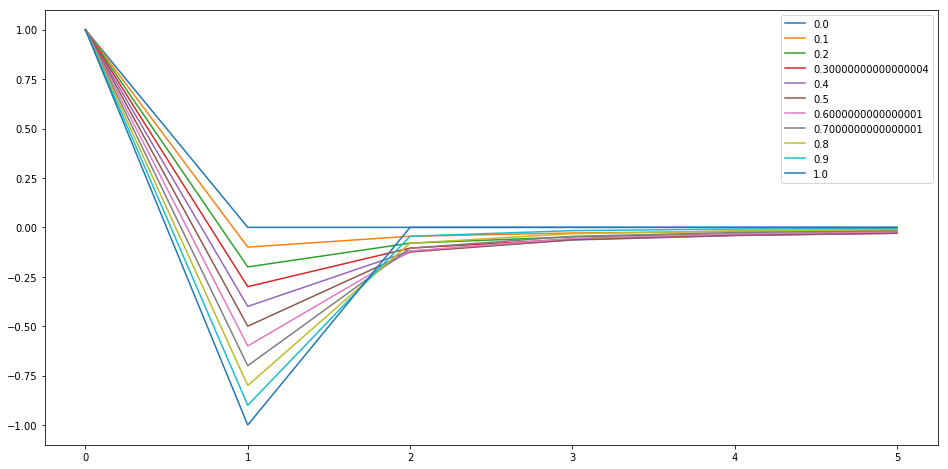

In [18]:
plot_weights([0, 1], 11, size=6)

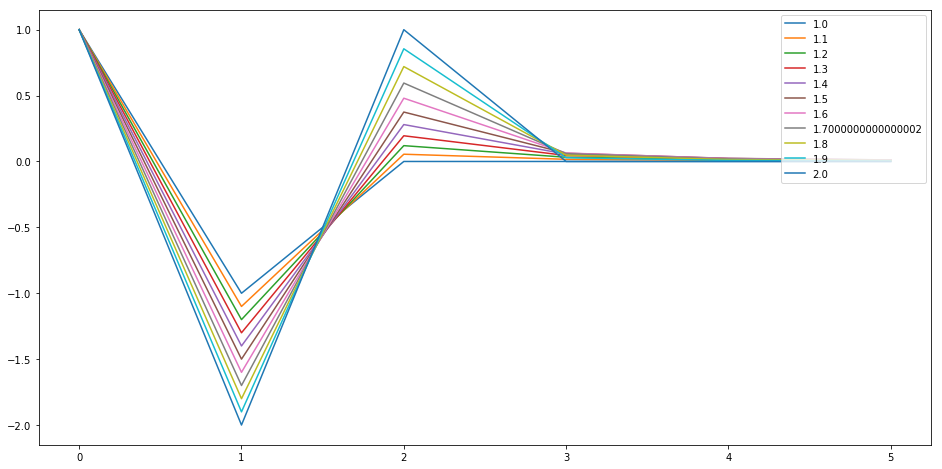

In [21]:
plot_weights([1, 2], 11, size=6)

In [23]:
def frac_diff(series, d, thres=.1):
    # w.shape = (series.shape[0], 1)
    w = get_weights(d, series.shape[0])
    w_sum = np.cumsum(abs(w))
    w_sum /= w_sum[-1]
    # Usable only after going over the threshold
    skip = w_sum[w_sum > thres].shape[0]
    df = {}
    for name in series.columns:
        series_f = series[[name]].fillna(method='ffill').dropna()
        df_ = pd.Series()
        for iloc in range(skip, series_f.shape[0]):
            loc = series_f.index[iloc]
            if not np.isfinite(series.loc[loc, name]):
                continue
            df_[loc] = np.dot(w[-(iloc + 1):, :].T, series_f.loc[:loc])[0, 0]
        df[name] = df_.copy(deep=True)
    df = pd.concat(df, axis=1)
    return df

In [29]:
def frac_diff_FFD(series, d, thres=1e-5):
    w = get_weights_FFD(d, thres)
    width = len(w) - 1
    df = {}
    for name in series.columns:
        series_f = series[[name]].fillna(method='ffill').dropna()
        df_ = pd.Series()
        for iloc1 in range(width, series_f.shape[0]):
            loc0 = series_f.index[iloc1 - width]
            loc1 = series_f.index[iloc1]
            if not np.isfinite(series.loc[loc1, name]):
                continue
            df_[loc1] = np.dot(w.T, series_f.loc[loc0:loc1])[0, 0]
        df[name] = df_.copy(deep=True)
    df = pd.concat(df, axis=1)
    return df

In [34]:
from statsmodels.tsa.stattools import adfuller

adfuller(close, 12)

(-2.4310671816546257,
 0.13315919893985956,
 1,
 3123,
 {'1%': -3.432445639802861,
  '10%': -2.567262891276225,
  '5%': -2.8624659237441654},
 25325.977157525936)

In [54]:
outputs = []
ds = np.linspace(0, 1, 11)
for d in ds:
    df1 = np.log(df[['Close']]).resample('1D').last()
    df2 = frac_diff(df1, d, thres=.1)
    df2 = adfuller(df2['Close'], maxlag = 1,regression = 'c',autolag = None)
    # Pvalue
    outputs.append(df2[1])


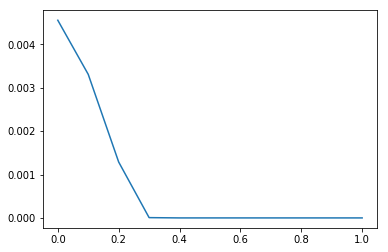

In [55]:
plt.plot(ds, outputs)

# 5.1

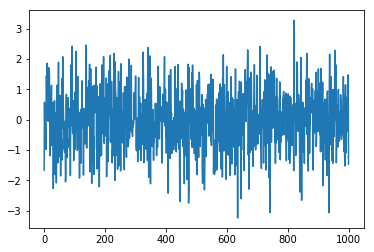

In [56]:
x = np.random.randn(1000)
plt.plot(x)

In [59]:
from statsmodels.tsa.stattools import adfuller


res = adfuller(x)
print(res)

p_val = res[1]
print("p-value: ", p_val)

(-31.905979494673552, 0.0, 0, 999, {'1%': -3.4369127451400474, '5%': -2.864437475834273, '10%': -2.568312754566378}, 2744.9799689994315)
p-value:  0.0


(-1.7324040052536145, 0.41449900866338485, 0, 999, {'1%': -3.4369127451400474, '5%': -2.864437475834273, '10%': -2.568312754566378}, 2740.3688716795396)
p-value:  0.41449900866338485


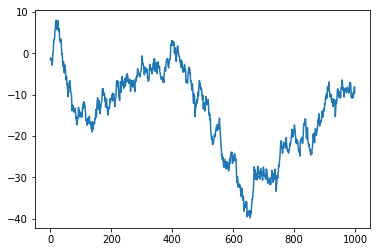

In [68]:
x_sum = x.cumsum()
plt.plot(x_sum)
res = adfuller(x_sum)
print(res)

p_val = res[1]
print("p-value: ", p_val)

(-12.139762946417354, 1.661395085541486e-22, 18, 979, {'1%': -3.4370471695043037, '5%': -2.8644967585264784, '10%': -2.5683443301882956}, 2807.9723875727504)
p-value:  1.661395085541486e-22


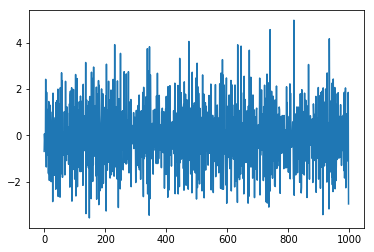

In [69]:
over_diff = np.diff(np.diff(x_sum))
plt.plot(over_diff)
res = adfuller(over_diff)
print(res)

p_val = res[1]
print("p-value: ", p_val)

# 5.2

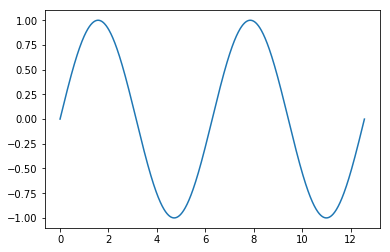

In [70]:
x = np.linspace(0, 4*np.pi, 1000)
y = np.sin(x)
plt.plot(x, y)

In [71]:
res = adfuller(y)
print(res)

p_val = res[1]
print("p-value: ", p_val)

(-61176890433966.41, 0.0, 13, 986, {'1%': -3.4369994990319355, '5%': -2.8644757356011743, '10%': -2.5683331327427803}, -66474.11444723718)
p-value:  0.0


# 5.4

In [95]:
def get_weights_FFD(d, thres, size=10000):
    w = [1.]
    for k in range(1, size):
        w_ = -w[-1] / k * (d - k + 1)
        if abs(w_) <= thres:
            break
        w.append(w_)
    w = np.array(w[::-1]).reshape(-1, 1)
    return w

def frac_diff_FFD(series, d, thres=1e-5):
    w = get_weights_FFD(d, thres)
    width = len(w) - 1
    df = {}
    for name in series.columns:
        series_f = series[[name]].fillna(method='ffill').dropna()
        df_ = pd.Series()
        for iloc1 in range(width, series_f.shape[0]):
            loc0 = series_f.index[iloc1 - width]
            loc1 = series_f.index[iloc1]
            if not np.isfinite(series.loc[loc1, name]):
                continue
            df_[loc1] = np.dot(w.T, series_f.loc[loc0:loc1])[0, 0]
        df[name] = df_.copy(deep=True)
    df = pd.concat(df, axis=1)
    return df

In [97]:
df_ = df[['Close', 'High', 'Low', "Open"]]
frac_df = frac_diff_FFD(df_, .5)
frac_df.head()

,Close,High,Low,Open
2008-04-24,24.432826,26.159592,29.164904,28.995048
2008-04-25,25.004480,24.093487,29.249048,25.077190
2008-04-28,31.250104,27.124649,22.162213,19.655443
2008-04-29,32.286958,30.688789,33.176407,26.948524
2008-04-30,42.889601,47.390843,35.226988,35.364104


In [100]:
frac_df = frac_diff_FFD(frac_diff_FFD(df_, 1), -1)
frac_df.head()

,Close,High,Low,Open


In [108]:
corrs = []
ds = []
for d in np.linspace(0, 2, 11):
    frac_df = frac_diff_FFD(df[['Close']], d)
    close_frac = frac_df["Close"]
    corr = close_frac.corr(close)
    print(d, close_frac.corr(close))
    if np.isfinite(corr):
        corrs.append(corr)
        ds.append(d)

0.0 0.9999999999999999
0.2 nan
0.4 0.6556192574489947
0.6000000000000001 0.35082490748313333
0.8 0.1290666758781033
1.0 0.027335619975316933
1.2000000000000002 0.002155285811621113
1.4000000000000001 -0.004320774399616829
1.6 -0.004306157040487879
1.8 -0.0033478392966258576
2.0 -0.0011334731368665776


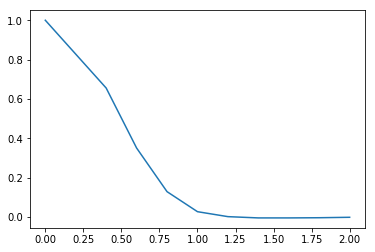

In [109]:
plt.plot(ds, corrs)

In [123]:
import statsmodels

ps = []
ds = []
for d in np.linspace(0, 2, 11):
    frac_df = frac_diff_FFD(df[['Close']], d)
    close_frac = frac_df["Close"]
    close_ = close.loc[close_frac.index]
    if len(close_) > 0:
        res = statsmodels.tsa.stattools.coint(close_, close_frac)
        ps.append(res[1])
        ds.append(d)

/home/tom/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1018: UserWarning: y0 and y1 are perfectly colinear.  Cointegration test is not reliable in this case.
  warnings.warn("y0 and y1 are perfectly colinear.  Cointegration test "


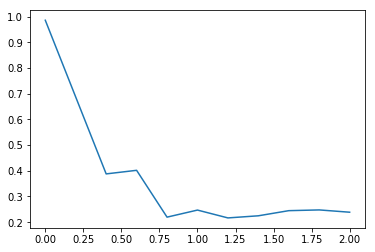

In [124]:
plt.plot(ds, ps)

In [125]:
ps

[0.9859002580259643,
 0.38787422100760127,
 0.4018158882081084,
 0.2195857998250862,
 0.2470845683515951,
 0.21656053528658742,
 0.2248046051799174,
 0.2447923057352438,
 0.2476560968184982,
 0.23874382890369555]